# Import Packages

In [1]:
import msgspec
import pandas as pd
import ast
from collections import Counter
import numpy as np

# Filter for User dataset
Our project focuses on restaurants and users in Pennsylvania ('state'== 'PA'). Due to the missing geolocation information for the User dataset, we are going to filter for users who have at least one review about PA restaurants.

## Filter for PA Restaurants

In [2]:
## Read the Business dataset
def stream_jsonl(filename):
    with open(filename, "r", encoding="utf-8") as file:
        for i, line in enumerate(file):
            yield msgspec.json.decode(line.strip())


# Convert streamed data to a Pandas DataFrame
business_df = pd.DataFrame(stream_jsonl(
    "../Yelp JSON/yelp_dataset/yelp_academic_dataset_business.json"))
print(business_df.head())

              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.9555

In [22]:
## Filter for business in Pennsylvania
PA_biz = business_df[(business_df['state'] == 'PA') & (business_df['is_open'] == 1)]

## Filter for business that has "Restaurant" in their categories
# First, split the categories into separate strings
restaurant_category_counts = PA_biz['categories'].dropna().str.split(', ').explode()

# Check what are the categories that contain the word "restaurant"
restaurant_category_counts = restaurant_category_counts[restaurant_category_counts.str.lower().str.contains('restaurant', na=False)].value_counts()
print("Count of Each Restaurant-Related Category:")
print(restaurant_category_counts)

PA_biz.loc[:, 'categories'] = PA_biz['categories'].astype(str)
unique_categories = sorted(PA_biz['categories'].str.split(', ').explode().unique())

# Find categories with "restaurant"
restaurant_related_categories = sorted([cat for cat in unique_categories if 'restaurant' in cat.lower()])
print("Unique Business Categories Containing 'Restaurant:")
for category in restaurant_related_categories:
    print(category)

PA_biz['categories'] = PA_biz['categories'].astype(str)

# Filter businesses where "Restaurants" is an exact category (not just part of a word)
PA_all_restaurant = PA_biz[PA_biz['categories'].str.split(', ').apply(lambda x: 'Restaurants' in x)]

print("Filtered Restaurant Businesses Shape:", PA_all_restaurant.shape)
PA_all_restaurant.head(3)

Count of Each Restaurant-Related Category:
Restaurants            8069
Pop-Up Restaurants       10
Restaurant Supplies       5
Name: categories, dtype: int64


/var/folders/9_/y5d0d5xj7ns0wpcgpkm97z280000gn/T/ipykernel_3606/2792378622.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PA_biz.loc[:, 'categories'] = PA_biz['categories'].astype(str)


Unique Business Categories Containing 'Restaurant:
Pop-Up Restaurants
Restaurant Supplies
Restaurants
Filtered Restaurant Businesses Shape: (8069, 14)


/var/folders/9_/y5d0d5xj7ns0wpcgpkm97z280000gn/T/ipykernel_3606/2792378622.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PA_biz['categories'] = PA_biz['categories'].astype(str)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.96,-75.16,4.00,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.95,-75.14,4.00,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.94,-75.16,4.50,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."


## Filter for Review dataset

In [23]:
review_df = pd.DataFrame(stream_jsonl(
    "../Yelp JSON/yelp_dataset/yelp_academic_dataset_review.json"))
print(review_df.head())

                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0   3.00       0      0     0   
1   5.00       1      0     1   
2   3.00       0      0     0   
3   5.00       1      0     1   
4   4.00       1      0     1   

                                                text                 date  
0  If you decide to eat here, just be aware it is...  2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year...  2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm...  2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delici

In [24]:
## Get the business ID from the filtered PA restaurant df
PA_rest_id = list(PA_all_restaurant['business_id'])
PA_restaurant_review = review_df[review_df['business_id'].isin(PA_rest_id)]
print(len(PA_restaurant_review))

836680


In [25]:
PA_user = PA_restaurant_review['user_id'].unique()
print(type(PA_user))
print(PA_user)

<class 'numpy.ndarray'>
['mh_-eMZ6K5RLWhZyISBhwA' '_7bHUi9Uuf5__HHc_Q8guQ'
 'Dd1jQj7S-BFGqRbApFzCFw' ... 'Q5l9zBUj9LtGYNWuEEueBQ'
 'Lt7xSv-7QIhKrctrXEwvxA' '7RAI4vRgimfsCfpjyVKD6w']


In [26]:
print(len(PA_user))

269462


In [27]:
PA_user_df = pd.DataFrame(PA_user, columns=['PA_user_id'])

## Filter for User Dataset

In [28]:
user = pd.DataFrame(stream_jsonl(
    "../Yelp JSON/yelp_dataset/yelp_academic_dataset_user.json"))
print(user.head())

                  user_id    name  review_count        yelping_since  useful  \
0  qVc8ODYU5SZjKXVBgXdI7w  Walker           585  2007-01-25 16:47:26    7217   
1  j14WgRoU_-2ZE1aw1dXrJg  Daniel          4333  2009-01-25 04:35:42   43091   
2  2WnXYQFK0hXEoTxPtV2zvg   Steph           665  2008-07-25 10:41:00    2086   
3  SZDeASXq7o05mMNLshsdIA    Gwen           224  2005-11-29 04:38:33     512   
4  hA5lMy-EnncsH4JoR-hFGQ   Karen            79  2007-01-05 19:40:59      29   

   funny   cool                                              elite  \
0   1259   5994                                               2007   
1  13066  27281  2009,2010,2011,2012,2013,2014,2015,2016,2017,2...   
2   1010   1003                           2009,2010,2011,2012,2013   
3    330    299                                     2009,2010,2011   
4     15      7                                                      

                                             friends  fans  ...  \
0  NSCy54eWehBJyZdG2iE84w, pe42

In [29]:
PA_user_df = user[user['user_id'].isin(PA_user)]
len(PA_user_df)

269461

### Process User Location
Use the reviewed restaurants location information to find the estimated user location, by averaging out all reviewed PA restaurants latitude and longitude

In [30]:
PA_review_with_location = PA_restaurant_review.merge(business_df[['latitude','longitude','business_id']], how='left', on='business_id')

PA_user_average_loc = PA_review_with_location.groupby('user_id').agg({
    'latitude': ['mean'],
    'longitude': ['mean']
}).reset_index()
print(PA_user_average_loc.head())

                  user_id latitude longitude
                              mean      mean
0  ---r61b7EpVPkb4UVme5tA    40.04    -75.49
1  --1oopX4BmrQEB_cW2dFVA    40.15    -75.27
2  --1vcleKg-_ORilNx_RaDw    40.19    -75.13
3  --2tyArRmSoyKx5r-FVG0A    39.95    -75.16
4  --2vR0DIsmQ6WfcSzKWigw    40.02    -75.06


In [31]:
PA_user_average_loc.reset_index(inplace=True)
print(PA_user_average_loc.head())

  index                 user_id latitude longitude
                                    mean      mean
0     0  ---r61b7EpVPkb4UVme5tA    40.04    -75.49
1     1  --1oopX4BmrQEB_cW2dFVA    40.15    -75.27
2     2  --1vcleKg-_ORilNx_RaDw    40.19    -75.13
3     3  --2tyArRmSoyKx5r-FVG0A    39.95    -75.16
4     4  --2vR0DIsmQ6WfcSzKWigw    40.02    -75.06


In [32]:
PA_user_with_avg_loc = PA_user_df.merge(PA_user_average_loc, on='user_id', how='left')
PA_user_with_avg_loc.head()

/var/folders/9_/y5d0d5xj7ns0wpcgpkm97z280000gn/T/ipykernel_3606/2459716757.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  PA_user_with_avg_loc = PA_user_df.merge(PA_user_average_loc, on='user_id', how='left')


/var/folders/9_/y5d0d5xj7ns0wpcgpkm97z280000gn/T/ipykernel_3606/2459716757.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  PA_user_with_avg_loc = PA_user_df.merge(PA_user_average_loc, on='user_id', how='left')


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,"(index, )","(latitude, mean)","(longitude, mean)"
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,18,232,844,467,467,239,180,229586,39.96,-75.17
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,251,1847,7054,3131,3131,1521,1946,198431,39.99,-75.19
2,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,147,1212,5696,2543,2543,815,323,229879,39.95,-75.16
3,AUi8MPWJ0mLkMfwbui27lg,John,109,2010-01-07 18:32:04,154,20,23,,"gy5fWeSv3Gamuq9Ox4MV4g, lMr3LWU6kPFLTmCpDkACxg...",4,...,0,1,6,3,3,0,0,48418,39.96,-75.17
4,1McG5Rn_UDkmlkZOrsdptg,Teresa,7,2009-05-26 16:11:11,18,3,13,,"piejMEdRkGB7-1aL4lL5NQ, X0zFOU6iG95-feQKOXkgrA...",1,...,0,1,0,2,2,0,0,9958,39.94,-75.16


In [33]:
PA_user_with_avg_loc.rename(columns={"('latitude', 'mean')":"avg_latitude","('longitude', 'mean')":"avg_longitude"},inplace=True)

In [34]:
PA_user_with_avg_loc.columns

Index([            'user_id',                'name',        'review_count',
             'yelping_since',              'useful',               'funny',
                      'cool',               'elite',             'friends',
                      'fans',       'average_stars',      'compliment_hot',
           'compliment_more',  'compliment_profile',     'compliment_cute',
           'compliment_list',     'compliment_note',    'compliment_plain',
           'compliment_cool',    'compliment_funny',   'compliment_writer',
         'compliment_photos',         ('index', ''),  ('latitude', 'mean'),
       ('longitude', 'mean')],
      dtype='object')

In [35]:
PA_user_with_avg_loc.to_csv('../Yelp JSON/PA_all_restaurant_user_with_loc.csv', index=False)

# User Data EDA

In [36]:
user = pd.read_csv('../Yelp JSON/PA_restaurant_user_with_loc.csv')
user.head()

/var/folders/9_/y5d0d5xj7ns0wpcgpkm97z280000gn/T/ipykernel_3606/2757492947.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  user = pd.read_csv('../Yelp JSON/PA_restaurant_user_with_loc.csv')


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,"('latitude', 'mean')","('longitude', 'mean')"
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,56,18,232,844,467,467,239,180,39.96,-75.17
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,157,251,1847,7054,3131,3131,1521,1946,39.99,-75.19
2,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,361,147,1212,5696,2543,2543,815,323,39.95,-75.16
3,AUi8MPWJ0mLkMfwbui27lg,John,109,2010-01-07 18:32:04,154,20,23,NaN,"gy5fWeSv3Gamuq9Ox4MV4g, lMr3LWU6kPFLTmCpDkACxg...",4,...,0,0,1,6,3,3,0,0,39.96,-75.17
4,1McG5Rn_UDkmlkZOrsdptg,Teresa,7,2009-05-26 16:11:11,18,3,13,NaN,"piejMEdRkGB7-1aL4lL5NQ, X0zFOU6iG95-feQKOXkgrA...",1,...,0,0,1,0,2,2,0,0,39.94,-75.16


In [37]:
user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', '('latitude', 'mean')', '('longitude', 'mean')'],
      dtype='object')

In [40]:
user['num_friends'] = user['friends'].apply(len)
user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', '('latitude', 'mean')', '('longitude', 'mean')',
       'num_friends'],
      dtype='object')

In [41]:
pd.options.display.float_format = '{:,.2f}'.format
user.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,"('latitude', 'mean')","('longitude', 'mean')",num_friends
count,"269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00","269,461.00"
mean,38.28,81.85,34.74,49.43,2.85,3.66,3.55,0.54,0.36,0.24,0.14,3.03,6.12,5.64,5.64,2.09,2.50,40.02,-75.21,"1,453.99"
std,140.04,"1,150.74",775.49,"1,019.21",36.12,1.06,119.88,14.75,20.74,9.16,8.02,145.58,239.22,164.63,164.63,52.32,146.24,0.11,0.15,"4,499.36"
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39.80,-75.80,4.00
25%,3.00,1.00,0.00,0.00,0.00,3.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39.95,-75.26,4.00
50%,8.00,4.00,1.00,1.00,0.00,3.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39.96,-75.17,46.00
75%,24.00,20.00,4.00,5.00,1.00,4.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,40.07,-75.15,"1,246.00"
max,"17,473.00","206,296.00","185,823.00","199,878.00","12,497.00",5.00,"25,784.00","4,347.00","7,039.00","2,974.00","2,607.00","59,031.00","101,097.00","49,967.00","49,967.00","15,934.00","56,104.00",40.45,-74.77,"359,878.00"


## EDA

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

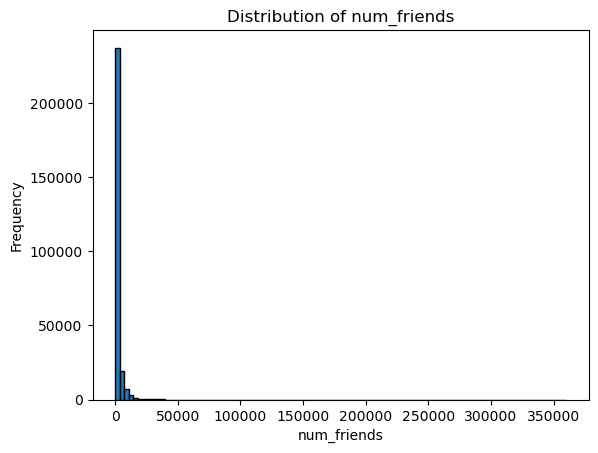

In [43]:
plt.hist(user['num_friends'], bins=100, edgecolor='black')  # 30 bins is a good starting point

# Customize the plot
plt.title('Distribution of num_friends')
plt.xlabel('num_friends')
plt.ylabel('Frequency')

plt.show()

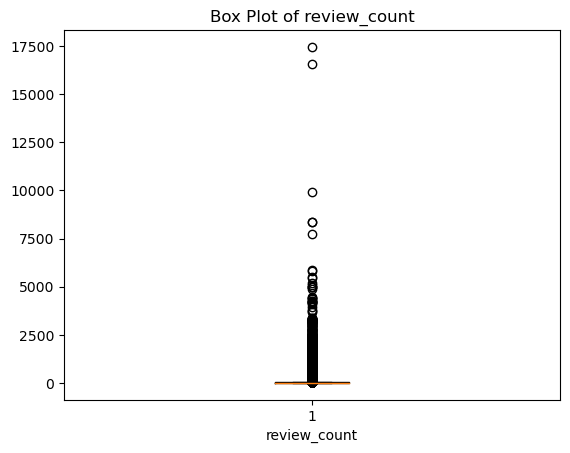

In [44]:
plt.boxplot(user['review_count'])

# Customize the plot
plt.title('Box Plot of review_count')
plt.xlabel('review_count')

plt.show()

In [45]:
Q1 = user['review_count'].quantile(0.25)  # First quartile
Q3 = user['review_count'].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

# Define the outlier bounds for 3 * IQR
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Count how many data points are outside the 3 * IQR range
outliers = user[(user['review_count'] < lower_bound) | (user['review_count'] > upper_bound)]

# Get the count of outliers
outliers_count = outliers.shape[0]

# Print the count of outliers
print(f"Number of data points outside the 3 * IQR range: {outliers_count}")

Number of data points outside the 3 * IQR range: 24537


In [46]:
print(lower_bound)
print(upper_bound)

-60.0
87.0


## Data Processing

In [48]:
bin_edges = [0, 10, 50, 500, 50000]  # Adjust as needed
bin_labels = ['Low', 'Medium', 'High', 'Very High']

user['review_count_binned'] = pd.cut(user['review_count'], bins=bin_edges, labels=bin_labels, include_lowest=True)

In [49]:
bin_stats = user.groupby('review_count_binned')['review_count'].agg(['count', 'mean', 'min', 'max', 'std'])
print(bin_stats)

                      count   mean  min    max    std
review_count_binned                                  
Low                  156982   3.99    0     10   2.69
Medium                74246  23.08   11     50  10.61
High                  35232 144.92   51    500 100.69
Very High              3001 956.04  501  17473 771.96


In [50]:
bin_edges = [0, 10, 50, 500, 500000]  # Adjust as needed
bin_labels = ['Low', 'Medium', 'High', 'Very High']

user['useful_binned'] = pd.cut(user['useful'], bins=bin_edges, labels=bin_labels, include_lowest=True)

In [51]:
bin_stats_useful = user.groupby('useful_binned')['useful'].agg(['count', 'mean', 'min', 'max', 'std'])
print(bin_stats_useful)

                count     mean  min     max      std
useful_binned                                       
Low            175350     2.53    0      10     2.84
Medium          57080    23.50   11      50    10.72
High            30560   150.87   51     500   106.41
Very High        6471 2,419.93  501  206296 7,028.86


In [52]:
bin_edges = [0, 10, 50, 500, 50000]  # Adjust as needed
bin_labels = ['Low', 'Medium', 'High', 'Very High']

user['fans_binned'] = pd.cut(user['fans'], bins=bin_edges, labels=bin_labels, include_lowest=True)

In [53]:
bin_stats_fans = user.groupby('fans_binned')['fans'].agg(['count', 'mean', 'min', 'max', 'std'])
print(bin_stats_fans)

              count     mean  min    max      std
fans_binned                                      
Low          257327     0.56    0     10     1.46
Medium         9434    22.42   11     50    10.29
High           2585   112.49   51    499    77.05
Very High       115 1,068.39  513  12497 1,213.94


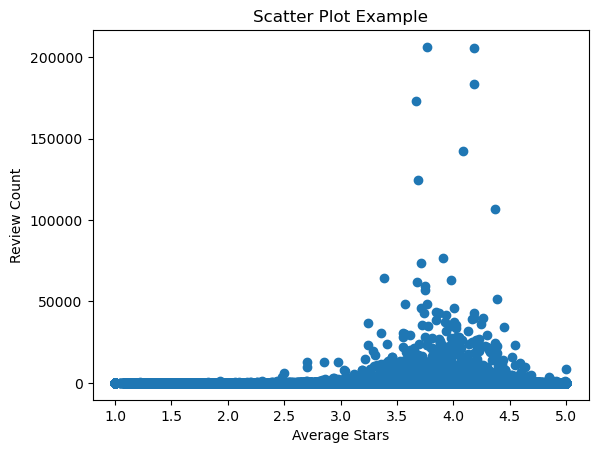

In [54]:
plt.scatter(user['average_stars'], user['useful'])

# Add labels and title
plt.xlabel("Average Stars")
plt.ylabel("Review Count")
plt.title("Scatter Plot Example")

# Show the plot
plt.show()

In [55]:
in_edges = [0, 10, 50, 500, 50000]  # Adjust as needed
bin_labels = ['Low', 'Medium', 'High', 'Very High']

user['compliment_hot_binned'] = pd.cut(user['compliment_hot'], bins=bin_edges, labels=bin_labels, include_lowest=True)

bin_stats_hot = user.groupby('compliment_hot_binned')['compliment_hot'].agg(['count', 'mean', 'min', 'max', 'std'])
print(bin_stats_hot)

                        count     mean  min    max      std
compliment_hot_binned                                      
Low                    263503     0.24    0     10     1.00
Medium                   4034    22.24   11     50    10.27
High                     1626   145.72   51    500   104.65
Very High                 298 1,906.04  503  25784 3,036.29


In [56]:
bin_edges = [0, 10, 500, 5000, 500000]  # Adjust as needed
bin_labels = ['Low', 'Medium', 'High', 'Very High']

user['num_friends_binned'] = pd.cut(user['num_friends'], bins=bin_edges, labels=bin_labels, include_lowest=True)

bin_stats_hot = user.groupby('num_friends_binned')['num_friends'].agg(['count', 'mean', 'min', 'max', 'std'])
print(bin_stats_hot)

                     count      mean   min     max       std
num_friends_binned                                          
Low                 109267      4.00     4       4      0.00
Medium               67370    144.19    22     478    132.22
High                 70595  2,019.30   502    4990  1,228.39
Very High            22229 10,755.73  5014  359878 11,725.64


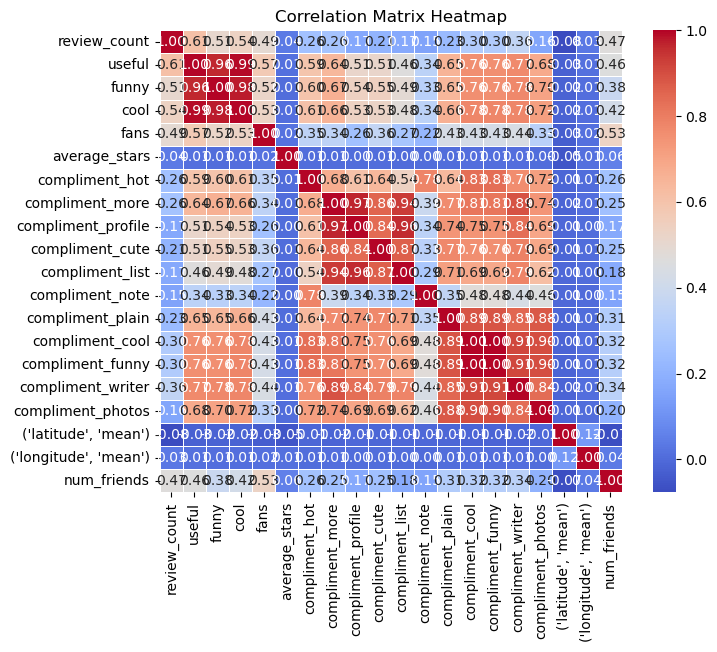

In [57]:
corr_matrix = user.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()